<a href="https://colab.research.google.com/github/ManideepAnnarapu/Skin_Cancer_Detection_Using_DeepLearning/blob/main/Skin_Cancer_Detection_using_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer Detection using TensorFlow and EfficientNetB7

This notebook demonstrates the process of building a deep learning model to classify skin cancer images as either benign or malignant. We will use the EfficientNetB7 model pre-trained on ImageNet and fine-tune it for our specific classification task.


In [32]:
#!pip install gdown

**Imports:** Import all necessary libraries for data processing, visualization, and deep learning

In [27]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetB0

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
import zipfile
import gdown
import os
import glob

## Step 1: Mount Google Drive

We mount Google Drive to access the dataset stored there. This allows us to work with large datasets seamlessly in the Google Colab environment.


## Step 2: Download Dataset

We download the dataset using `gdown`, a command-line tool that facilitates downloading large files from Google Drive.


## Step 3: Unzip Dataset

The downloaded dataset is in a zip file. We extract the contents to access the image files.


In [14]:
# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Download the zip file using gdown
url = 'https://drive.google.com/uc?id=1Nx53IB0O2aNqpA9zMAMOgvjCZEGPfWHh'
output = '/content/train_cancer.zip'
gdown.download(url, output, quiet=False)

# Step 3: Unzip the folder
with zipfile.ZipFile('/content/train_cancer.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/train_Cancer')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading...
From: https://drive.google.com/uc?id=1Nx53IB0O2aNqpA9zMAMOgvjCZEGPfWHh
To: /content/train_cancer.zip
100%|██████████| 6.65M/6.65M [00:00<00:00, 132MB/s]


## Step 5: Count Images

We count the total number of images in the dataset to verify its size. This helps us understand the dataset's scale and ensure completeness.


In [15]:
# Step 5: Count the images using the correct path
images = glob.glob('/content/train_Cancer/train_cancer/*/*.jpg')
print(len(images))

270


## Step 6: Standardize Paths

To avoid any potential issues with file paths, we standardize the paths by replacing backslashes with forward slashes.


In [16]:
# Step 6: Replace backslashes with forward slashes
images = [path.replace('\\', '/') for path in images]

## Step 7: Create DataFrame and Extract Labels

We create a DataFrame to organize the image file paths and extract the labels (benign or malignant) from the file paths. This structure will facilitate further processing and analysis.


In [17]:
# Step 7: Extract the labels based on the file path structure
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].apply(lambda x: x.split('/')[-2])
df.head()

,filepath,label
0,/content/train_Cancer/train_cancer/malignant/7...,malignant
1,/content/train_Cancer/train_cancer/malignant/2...,malignant
2,/content/train_Cancer/train_cancer/malignant/2...,malignant
3,/content/train_Cancer/train_cancer/malignant/2...,malignant
4,/content/train_Cancer/train_cancer/malignant/3...,malignant


## Step 8: Create Binary Labels

We convert the categorical labels into binary labels (0 for benign and 1 for malignant) for our classification task.


In [18]:
# Step 8: Binary labels
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()

,filepath,label,label_bin
0,/content/train_Cancer/train_cancer/malignant/7...,malignant,1
1,/content/train_Cancer/train_cancer/malignant/2...,malignant,1
2,/content/train_Cancer/train_cancer/malignant/2...,malignant,1
3,/content/train_Cancer/train_cancer/malignant/2...,malignant,1
4,/content/train_Cancer/train_cancer/malignant/3...,malignant,1


## Step 9: Plot Label Distribution

We visualize the distribution of labels to understand the dataset's balance. This helps us identify any potential class imbalance that could affect model performance.


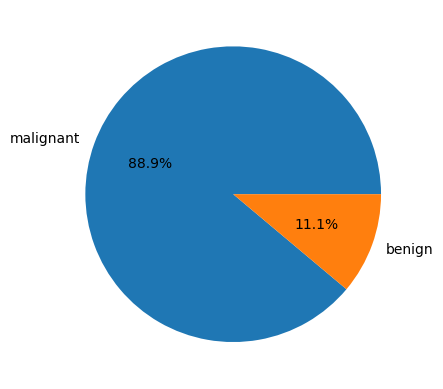

In [19]:
# Step 9: Plot label distribution
x = df['label'].value_counts()
plt.pie(x.values, labels=x.index, autopct='%1.1f%%')
plt.show()

## Step 10: Display Sample Images

We display sample images from each category (benign and malignant) to visually inspect the data. This helps us understand the variety and characteristics of the skin cancer images in the dataset.


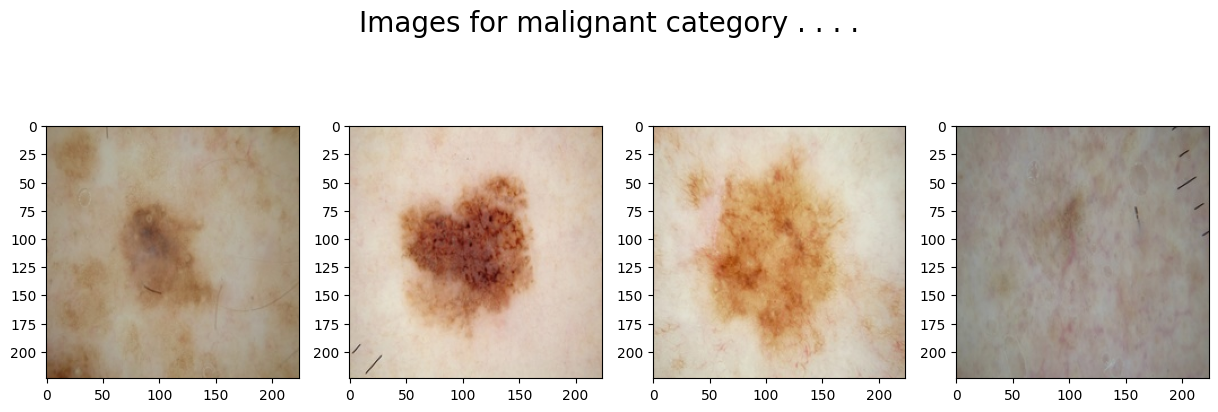

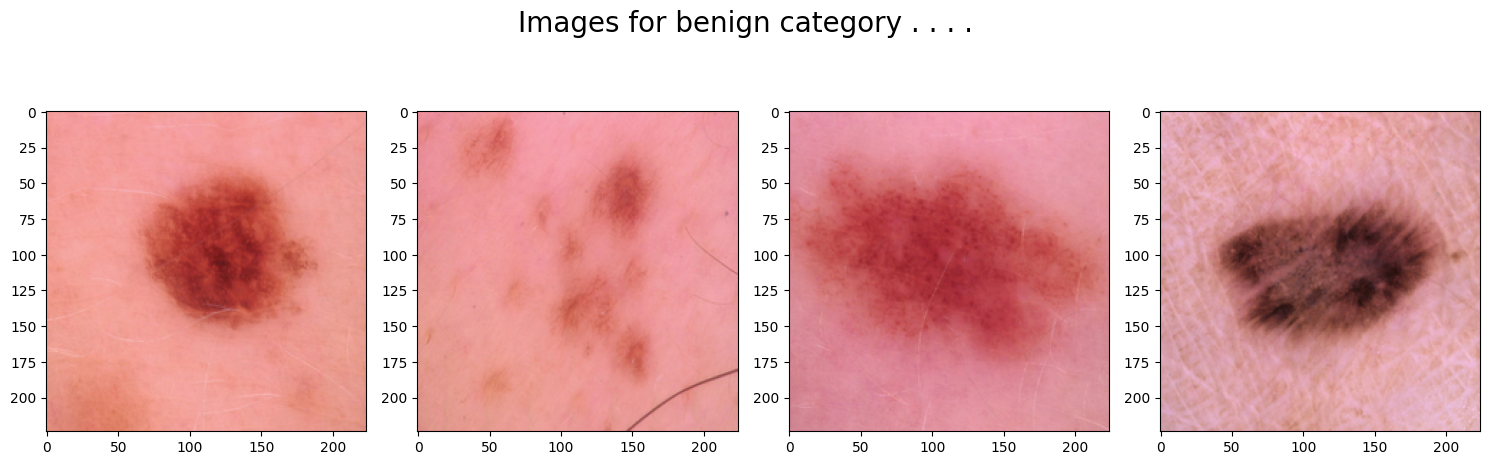

In [20]:
# Step 10: Display sample images
for cat in df['label'].unique():
    temp = df[df['label'] == cat]
    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]
        image_path = data['filepath']
        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()

## Step 11: Split Data into Training and Validation Sets

We split the dataset into training and validation sets to evaluate our model's performance on unseen data. This step is crucial for assessing the model's generalization capability.


In [21]:
# Step 11: Split data into training and validation sets
features = df['filepath']
target = df['label_bin']

X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.15, random_state=10)

X_train.shape, X_val.shape

((229,), (41,))

## Step 12: Define Image Decoding Function

We define a function to decode and preprocess images. This function will be used to prepare the images for input into the TensorFlow model.


In [22]:
# Step 12: Define image decoding function
def decode_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label


## Step 13: Create TensorFlow Datasets

We create TensorFlow datasets for efficient data loading and preprocessing. These datasets will be used during model training and validation.


In [23]:
# Step 13: Create TensorFlow datasets
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

## Step 14: Load Pre-trained EfficientNetB7 Model

We load the EfficientNetB7 model pre-trained on ImageNet. This model provides a strong starting point for our classification task, leveraging pre-trained weights to improve performance.


In [28]:
# Step 14: Load pre-trained model
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pre_trained_model = EfficientNetB7(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

for layer in pre_trained_model.layers:
    layer.trainable = False


## Step 15: Define the Complete Model Architecture

We define the complete model architecture by adding layers on top of the pre-trained EfficientNetB7 model. This includes global average pooling, dense layers, batch normalization, and dropout for regularization.


In [29]:
# Step 15: Define the model
inputs = layers.Input(shape=(224, 224, 3))
x = pre_trained_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

## Step 16: Compile the Model

We compile the model with a binary cross-entropy loss function and the Adam optimizer. We also specify the AUC metric to evaluate the model's performance.


In [30]:
# Step 16: Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['AUC']
)


## Step 17: Train the Model

We train the model on the training dataset and validate it on the validation dataset. We capture the training history to analyze the model's performance over epochs.


## Step 18: Visualize Training History

We visualize the training and validation loss and AUC over epochs to understand the model's learning process and evaluate its performance.


In [31]:
# Step 17: Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=5, verbose=1)

# Step 18: Visualize training history
hist_df = pd.DataFrame(history.history)
hist_df.head()

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 236s 24s/step - AUC: 0.5640 - loss: 1.0164 - val_AUC: 0.4583 - val_loss: 0.8609
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 205s 24s/step - AUC: 0.4791 - loss: 0.7511 - val_AUC: 0.2500 - val_loss: 0.6980
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 190s 23s/step - AUC: 0.5657 - loss: 0.5997 - val_AUC: 0.3639 - val_loss: 0.6124
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 192s 22s/step - AUC: 0.5501 - loss: 0.5448 - val_AUC: 0.5000 - val_loss: 0.5632
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 213s 24s/step - AUC: 0.5167 - loss: 0.4976 - val_AUC: 0.5000 - val_loss: 0.5606


,AUC,loss,val_AUC,val_loss
0,0.527549,0.953691,0.458333,0.860855
1,0.488333,0.730473,0.250000,0.697994
2,0.509118,0.601382,0.363889,0.612365
3,0.500980,0.550752,0.500000,0.563198
4,0.506667,0.494481,0.500000,0.560617


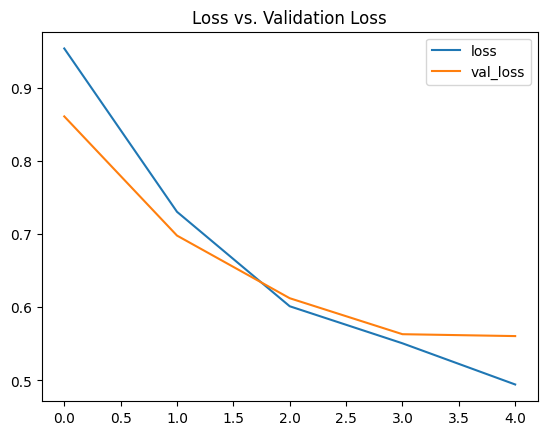

In [33]:
# Plot loss
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss vs. Validation Loss')
plt.legend()
plt.show()

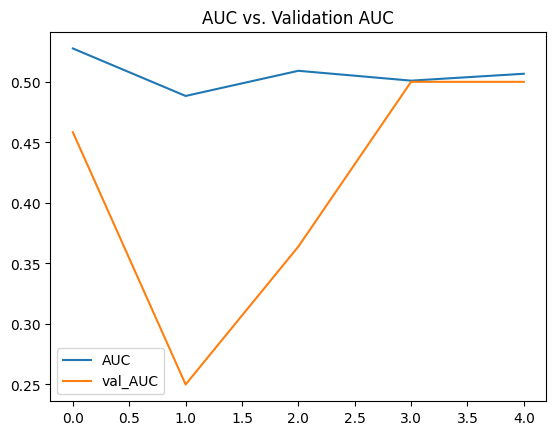

In [38]:
# Plot AUC
hist_df['AUC'].plot()
hist_df['val_AUC'].plot()
plt.title('AUC vs. Validation AUC')
plt.legend()
plt.show()

## Interpretation of Training and Validation Results

### Loss vs. Validation Loss

The first plot shows the training loss and validation loss over epochs:

1. **Training Loss**:
   - The training loss decreases consistently, indicating that the model is learning from the training data and improving its predictions.

2. **Validation Loss**:
   - The validation loss also decreases, suggesting that the model is not overfitting and generalizes well to unseen data.

Overall, the decreasing trend in both training and validation loss indicates that the model is training effectively.

### AUC vs. Validation AUC

The second plot shows the Area Under the Curve (AUC) for the training and validation sets:

1. **Training AUC**:
   - The training AUC starts high, dips slightly, and then stabilizes. This suggests that the model's ability to distinguish between classes initially fluctuated but then improved and became consistent.

2. **Validation AUC**:
   - The validation AUC shows more variability, with a significant dip and then recovery. This fluctuation may indicate some instability in the model's performance on the validation set, possibly due to the limited size of the validation data or the complexity of the task.

Despite the initial dip, both training and validation AUC converge to similar values, indicating that the model eventually learns to generalize well.

### Suggestions for Improvement

1. **More Epochs**:
   - Training the model for more epochs might help stabilize the AUC further and improve generalization.

2. **Data Augmentation**:
   - Implementing data augmentation techniques can help increase the diversity of the training data, making the model more robust.

3. **Hyperparameter Tuning**:
   - Experimenting with different learning rates, batch sizes, and other hyperparameters could lead to better model performance.

4. **Cross-Validation**:
   - Using cross-validation can provide a more reliable estimate of the model's performance and help mitigate the variability seen in the validation AUC.

### Conclusion

In this notebook, we demonstrated the process of building a deep learning model to classify skin cancer images using the EfficientNetB7 model. The training and validation results indicate that the model is learning effectively, though there is room for further improvement in terms of stability and performance. The visualizations of training history provide valuable insights into the model's learning dynamics, highlighting areas for potential refinement.
